<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/inferenceTotalSegmentatorNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the second step in the split workflow on Terra

The NIFTI files generated from first step are provided as input for Inference.


Please cite:

Jakob Wasserthal, Manfred Meyer, Hanns-Christian Breit, Joshy Cyriac, Shan Yang, & Martin Segeroth. (2022). TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. https://doi.org/10.48550/arXiv.2208.05868

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

###Installing Packages

In [1]:
# %%capture
# #Installing lz4 for compression/decompression
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 xvfb

In [2]:
%%capture
#Installing Totalsegmentator for Inference
#pyradiomics required for extracting radiomics features 
#nvidia-ml-py3 for capturing gpu utilization
!pip install TotalSegmentator pyradiomics nvidia-ml-py3

###Parameters for papermill

In [3]:
converterType='dcm2niix'
niftiFilePath=''

###Decompressing NIFTI files from first step

In [5]:
import glob

#Get the file path of the 

niftiFilePath = '/content/drive/MyDrive/idc/submissions_6f98b2f4-5595-4580-b2cc-60243e24f058_TotalSegmentator_ef2b861c-87e3-49b8-888e-0ec494026e24_call-downloadAndConvert_downloadDicomAndConvertNiftiFiles.tar.lz4'


!lz4 -d {niftiFilePath} -c | tar  --strip-components=1  -xvf -

#!lz4 -d /content/drive/MyDrive/idc_vamsi/downloadDicomAndConvertNiftiFiles.tar.lz4 -c | tar xvf -

cromwell_root/dcm2niix/
cromwell_root/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763/
cromwell_root/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763/1.3.6.1.4.1.14519.5.2.1.7009.9004.17313147964480306532752553676_2_OPA_GE_LS16_STANDARD_440_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
cromwell_root/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437/
cromwell_root/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437/1.3.6.1.4.1.14519.5.2.1.7009.9004.65896688214410558172718370543_2_OPA_GE_LS16_STANDARD_300_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
cromwell_root/dcm2niix/1.2.840.113654.2.55.304509822326866716583270698596704114762/
cromwell_root/dcm2niix/1.2.840.113654.2.55.304509822326866716583270698596704114762/1.2.840.113654.2.55.304509822326866716583270698596704114762_1_OPA_SE_VZOOM_B30f_273_2_120_75_40_na_20000102000000_101.nii.gz
cromwell_root/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.533

###Defining Functions

In [6]:
import os
import sys
import shutil
from pathlib import Path
import time
import subprocess

In [7]:
#create directory for TotalSegmentator Output files
try:
  shutil.rmtree('Inference')
  shutil.rmtree('metadata')
except OSError:
  pass
os.mkdir('Inference')
os.mkdir('metadata')

In [8]:
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Fri Mar 31 17:55:43 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


In [9]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import nvidia_smi

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total

In [10]:
def inferenceTotalSegmentator(series_id):
      try:
        shutil.rmtree(f'Inference/{series_id}')
        shutil.rmtree(f'metadata/{series_id}')
        os.remove('segmentations.nii.gz')
        os.remove('statistics_radiomics.json')
        os.remove('preview_total.png')
      except OSError:
        pass
      os.mkdir(f'Inference/{series_id}')
      os.mkdir(f'metadata/{series_id}')

      print("Processing series: "+series_id)  

      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)
  

      start_time = time.time()
      !TotalSegmentator -i {nifti_filename_path} -o segmentations --ml --fast --preview  --radiomics 
      total_segmentator_time = time.time() - start_time

      try:
        subprocess.run(["mv", f"{curr_dir}/preview_total.png", f"{curr_dir}/segmentations.nii", f"{curr_dir}/statistics_radiomics.json", f"{curr_dir}/Inference/{series_id}/"], check=True)
        print("Files moved successfully using the first command")
      except subprocess.CalledProcessError:
        try:
            subprocess.run(["mv", "segmentations/preview_total.png", "segmentations/segmentations.nii", "segmentations/statistics_radiomics.json", f"{curr_dir}/Inference/{series_id}/"], check=True)
            print("Files moved successfully using the second command")
        except subprocess.CalledProcessError:
                print("Error: Failed to move files using both commands")
        
      #!mv {curr_dir}/preview_total.png {curr_dir}/segmentations.nii {curr_dir}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/
      !mv {curr_dir}/Inference/{series_id}/segmentations.nii {curr_dir}/Inference/{series_id}/{series_id}.nii
      !mv {curr_dir}/Inference/{series_id}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json      
      !mv {curr_dir}/Inference/{series_id}/preview_total.png {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png

      start_time = time.time()  
      !lz4 {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}.nii.lz4
      !tar cvf - {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png | lz4 > {curr_dir}/metadata/{series_id}/{series_id}_metadata.tar.lz4
      archiving_time = time.time() - start_time

      log['total_segmentator_time']=total_segmentator_time
      log['archiving_time'] = archiving_time
      

      !rm -r {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png
      !rm -r {curr_dir}/{converterType}/{series_id}
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

###Total Segmentator

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Download finished. Extracting...
  downloaded in 165.49s
Resampling...
  Resampled in 6.38s
Predicting...
  Predicted in 17.02s
Generating preview...
  Generated in 4.83s
Resampling...
Saving segmentations...
  Saved in 3.41s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Files moved successfully using the first command
Compressed 112733632 bytes into 3195720 bytes ==> 2.83%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437/1.3.6.1.4.1.14519.5.2.1.7009.90

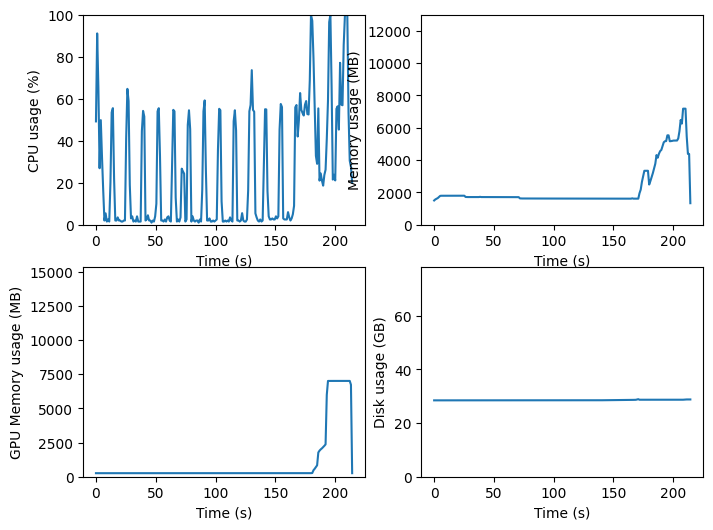

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.98s
Predicting...
  Predicted in 7.46s
Generating preview...
  Generated in 4.28s
Resampling...
Saving segmentations...
  Saved in 2.29s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Files moved successfully using the first command
Compressed 119287232 bytes into 2340430 bytes ==> 1.96%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250/1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250/1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250_preview_total.png


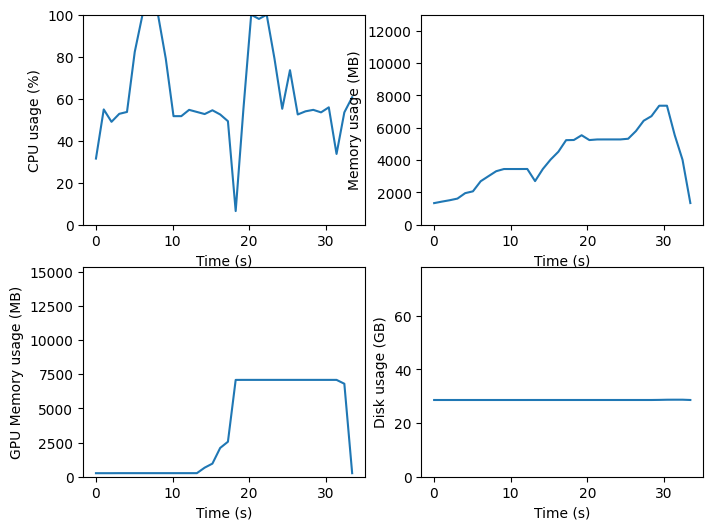

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 8.35s
Predicting...
  Predicted in 9.01s
Generating preview...
  Generated in 9.45s
Resampling...
Saving segmentations...
  Saved in 3.60s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.14s
Files moved successfully using the first command
Compressed 136064448 bytes into 2866863 bytes ==> 2.11%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843_preview_total.png


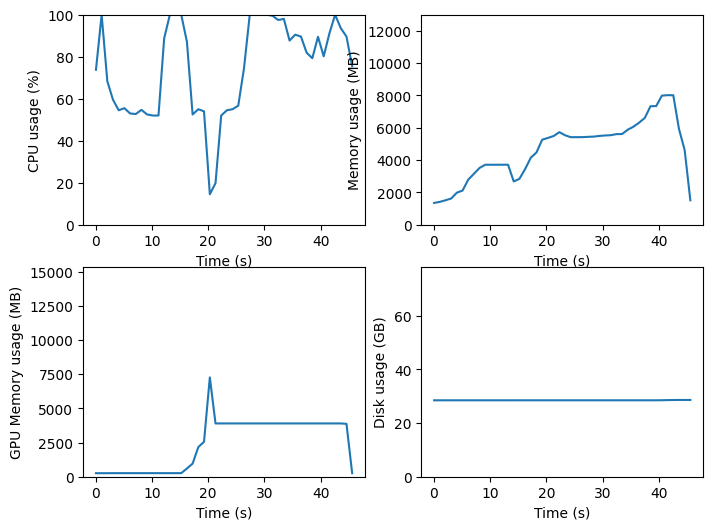

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.39s
Predicting...
  Predicted in 8.33s
Generating preview...
  Generated in 6.64s
Resampling...
Saving segmentations...
  Saved in 2.24s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.13s
Files moved successfully using the first command
Compressed 117714368 bytes into 2605400 bytes ==> 2.21%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216/1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216/1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216_preview_total.png


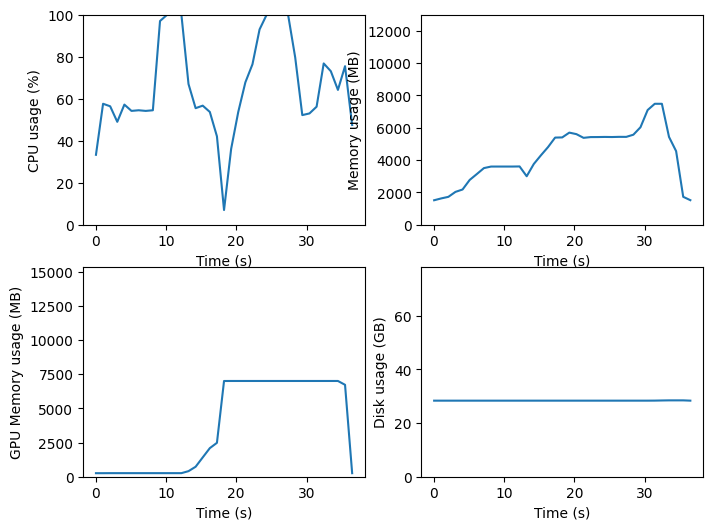

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.83s
Predicting...
  Predicted in 10.52s
Generating preview...
  Generated in 4.96s
Resampling...
Saving segmentations...
  Saved in 3.50s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Files moved successfully using the first command
Compressed 119025088 bytes into 2855962 bytes ==> 2.40%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330_preview_total.png


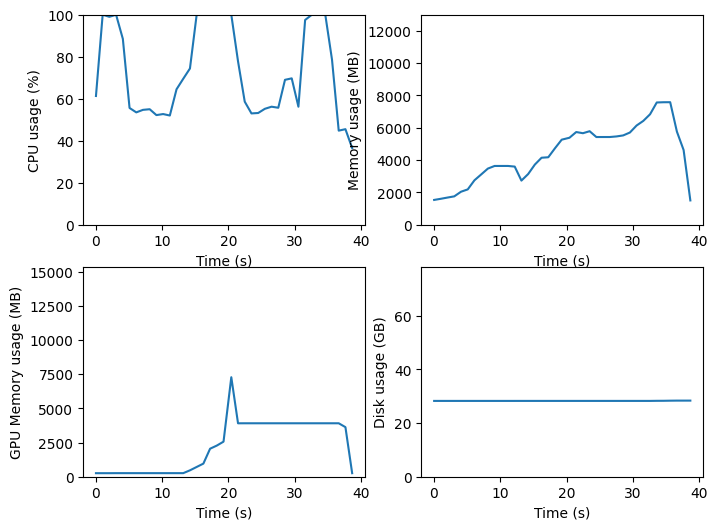

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.26s
Predicting...
  Predicted in 7.35s
Generating preview...
  Generated in 4.72s
Resampling...
Saving segmentations...
  Saved in 2.63s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Files moved successfully using the first command
Compressed 120073664 bytes into 2640353 bytes ==> 2.20%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334/1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334/1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334_preview_total.png


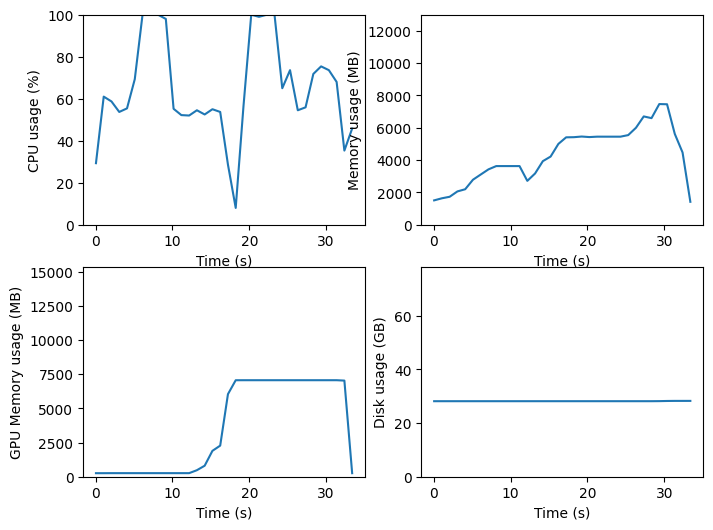

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.70s
Predicting...
  Predicted in 9.62s
Generating preview...
  Generated in 6.22s
Resampling...
Saving segmentations...
  Saved in 1.62s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Files moved successfully using the first command
Compressed 120073664 bytes into 2860745 bytes ==> 2.38%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518/1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518/1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518_preview_total.png


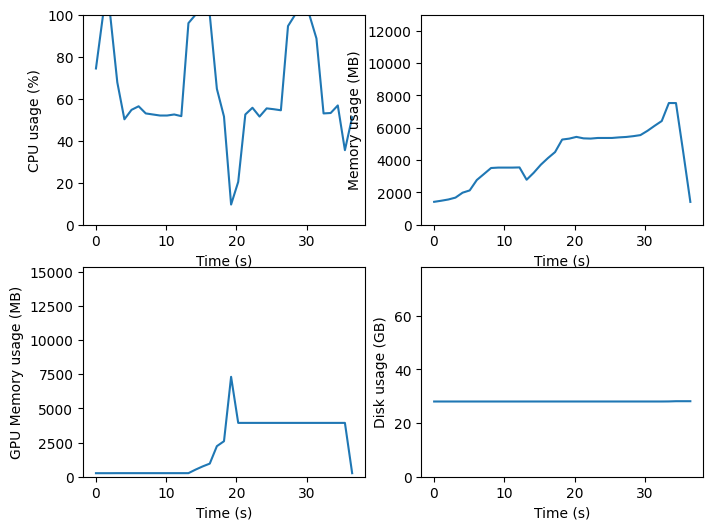

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.86s
Predicting...
  Predicted in 10.98s
Generating preview...
  Generated in 4.23s
Resampling...
Saving segmentations...
  Saved in 1.63s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.12s
Files moved successfully using the first command
Compressed 119811520 bytes into 3566107 bytes ==> 2.98%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890/1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890/1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890_preview_total.png


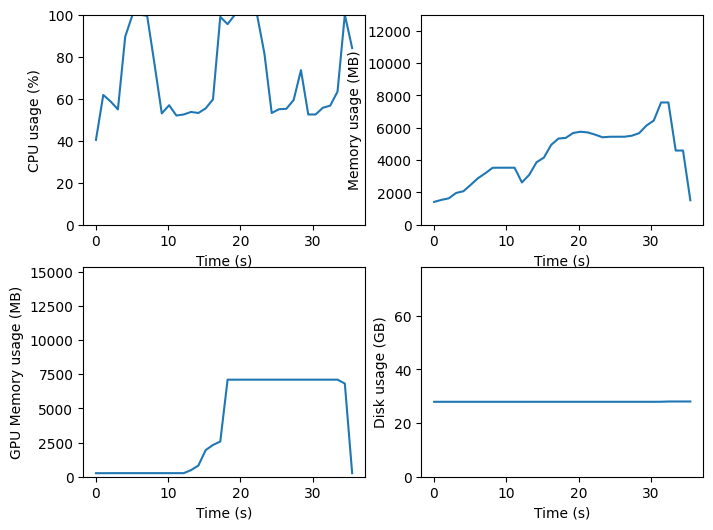

Processing series: 1.2.840.113654.2.55.304509822326866716583270698596704114762

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 0.47s
Predicting...
  Predicted in 6.65s
Generating preview...
  Generated in 3.97s
Resampling...
Saving segmentations...
  Saved in 0.04s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.09s
Files moved successfully using the first command
Compressed 3157440 bytes into 140024 bytes ==> 4.43%
tar: Removing leading `/' from member names
/content/Inference/1.2.840.113654.2.55.304509822326866716583270698596704114762/1.2.840.113654.2.55.304509822326866716583270698596704114762_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.2.840.113654.2.55.304509822326866716583270698596704114762/1.2.840.113654.2.55.304509822326866716583270698596704114762_preview_total.png


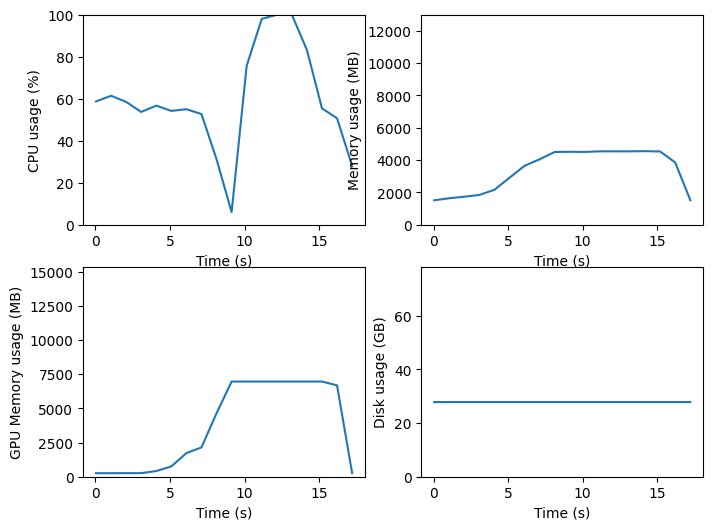

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.70s
Predicting...
  Predicted in 12.11s
Generating preview...
  Generated in 6.59s
Resampling...
Saving segmentations...
  Saved in 3.01s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Files moved successfully using the first command
Compressed 117190080 bytes into 2259174 bytes ==> 1.93%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763_preview_total.png


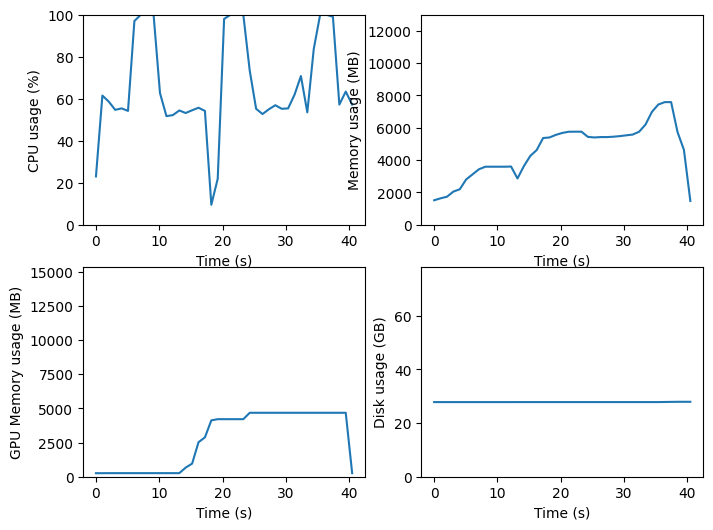

In [11]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'{curr_dir}/{converterType}'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(inferenceTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [14]:
start_time = time.time()
try:
  os.remove('inferenceNiftiFiles.tar.lz4')
  os.remove('metadata.tar.lz4')
except OSError:
  pass
!tar cvf - Inference | lz4 > inferenceNiftiFiles.tar.lz4
!tar cvf - metadata | lz4 > inferenceMetaData.tar.lz4
archiving_time = time.time() - start_time


Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250/1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216/1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330/
Inference/1.3.6.1

###Utilization Metrics

In [13]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['archiving_time']=archiving_time
try:
  os.remove('inferenceUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv inferenceUsageMetrics.lz4
runtime_stats

Compressed 28733 bytes into 11049 bytes ==> 38.45%


,SeriesInstanceUID,total_segmentator_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,gpu_usage_mb,gpu_total_mb,gpu_type,disk_usage_all,disk_total
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144...,214.087008,0.121841,"[[[49.2, 91.1, 65.3, 26.9, 49.8, 32.2, 16.3, 2...","[[[1499.16015625, 1565.20703125, 1602.88671875...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 261...",[15360.0],b'Tesla T4',"[[[28.434276580810547, 28.434284210205078, 28....",78.189842
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747...,32.652381,0.121841,"[[[31.5, 54.9, 49.0, 52.8, 53.7, 82.3, 100.0, ...","[[[1335.74609375, 1429.07421875, 1514.0703125,...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.567344665527344, 28.567352294921875, 28....",78.189842
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465...,45.442396,0.121841,"[[[73.8, 100.0, 68.3, 59.5, 54.5, 55.5, 53.0, ...","[[[1345.55078125, 1414.74609375, 1511.796875, ...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.452686309814453, 28.452693939208984, 28....",78.189842
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111...,35.624037,0.121841,"[[[33.3, 57.6, 56.4, 49.0, 57.2, 54.2, 54.5, 5...","[[[1513.28125, 1627.26953125, 1723.60546875, 2...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.320358276367188, 28.320358276367188, 28....",78.189842
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428...,38.006840,0.121841,"[[[61.3, 100.0, 99.0, 100.0, 88.5, 55.6, 53.5,...","[[[1533.0234375, 1604.046875, 1680.55859375, 1...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.22576904296875, 28.22577667236328, 28.22...",78.189842
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042...,32.962919,0.121841,"[[[29.3, 61.0, 58.7, 53.7, 55.4, 69.3, 100.0, ...","[[[1505.61328125, 1634.71875, 1728.6875, 2059....",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.12044906616211, 28.12045669555664, 28.12...",78.189842
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704...,36.408391,0.121841,"[[[74.4, 100.0, 100.0, 67.8, 50.2, 54.7, 56.4,...","[[[1415.80859375, 1483.4296875, 1560.76171875,...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.00558853149414, 28.005596160888672, 28.0...",78.189842
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643...,34.812447,0.121841,"[[[40.4, 61.8, 58.7, 54.9, 89.6, 100.0, 100.0,...","[[[1411.671875, 1535.125, 1632.1640625, 1963.4...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.895809173583984, 27.895816802978516, 27....",78.189842
8,1.2.840.113654.2.55.30450982232686671658327069...,16.402676,0.121841,"[[[58.7, 61.4, 58.5, 53.7, 56.7, 54.2, 55.0, 5...","[[[1511.0, 1636.40625, 1731.31640625, 1841.933...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 415...",[15360.0],b'Tesla T4',"[[[27.791088104248047, 27.791095733642578, 27....",78.189842
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644...,40.390726,0.121841,"[[[23.0, 61.5, 58.6, 54.7, 55.4, 54.2, 97.0, 1...","[[[1511.828125, 1632.89453125, 1731.52734375, ...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.78783416748047, 27.787841796875, 27.7878...",78.189842
